In [27]:
import tensorflow as tf
from tensorflow.keras import models, layers, applications
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
# Constants
IMAGE_SIZE = 299  # Adjusted for Inception v4
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 50


In [29]:
# Data Pipeline
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/tanishkhot/Coding/BlindScan/Dataset/Final_Dataset_1800",        #Chaneg it here
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 1886 files belonging to 8 classes.


In [30]:
# Function to partition dataset remains the same
def partition_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  if shuffle:
    ds=ds.shuffle(shuffle_size, seed = 12)

  ds_size = len(ds)
  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = partition_dataset(dataset)

In [31]:
# Data Preprocessing for Inception v4
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),  # Inception v4 expects pixel values in [-1, 1]
    layers.experimental.preprocessing.Resizing(299,299) 
])


In [32]:
# Prepare the datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [33]:
# Load InceptionV4 model pre-trained on ImageNet
base_model = applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
base_model.trainable = False  # Freeze the base model

In [34]:
# Custom layers on top of Inception v4
model = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='softmax')  # Assuming 8 classes for note classification
])


In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [36]:

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric.
)


In [37]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/50
94/94 [==============================] - 197s 2s/step - loss: 1.4071 - accuracy: 0.5153 - val_loss: 0.9405 - val_accuracy: 0.6761
Epoch 2/50
94/94 [==============================] - 176s 2s/step - loss: 0.6599 - accuracy: 0.7976 - val_loss: 0.4981 - val_accuracy: 0.8693
Epoch 3/50
94/94 [==============================] - 145s 2s/step - loss: 0.4092 - accuracy: 0.8915 - val_loss: 0.4491 - val_accuracy: 0.8750
Epoch 4/50
94/94 [==============================] - 149s 2s/step - loss: 0.2881 - accuracy: 0.9354 - val_loss: 0.3540 - val_accuracy: 0.8807
Epoch 5/50
94/94 [==============================] - 171s 2s/step - loss: 0.2217 - accuracy: 0.9447 - val_loss: 0.2912 - val_accuracy: 0.9205
Epoch 6/50
94/94 [==============================] - 165s 2s/step - loss: 0.1513 - accuracy: 0.9754 - val_loss: 0.2106 - val_accuracy: 0.9261
Epoch 7/50
94/94 [==============================] - 165s 2s/step - loss: 0.1199 - accuracy: 0.9834 - val_loss: 0.2397 - val_accuracy: 0.9091
Epoch 8/50
94

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training And Validation Loss')

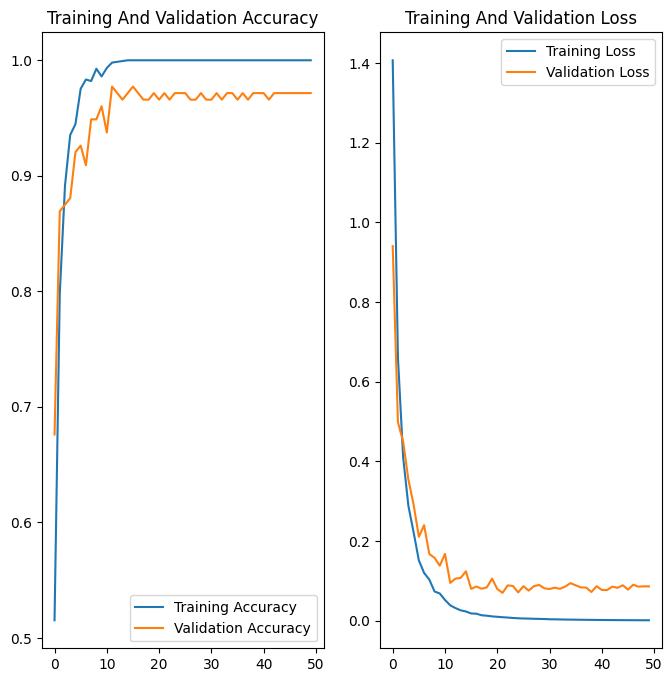

In [39]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training And Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training And Validation Loss')


In [41]:
model.save('my_inceptionv4_model.h5')
model.save('my_inceptionv4_model.keras')


